In [1]:
import drawing
import numpy as np

import os

import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

n_mixtures = 20
hidden_size = 400
input_size = 3
batch_size = 256
n_epochs = 1000
max_length = 1200
lr = 1e-3
seq_len = 700
step_len = 100
eps = 1e-6
model_name = "20210811_Prediction-3LSTM-20Mixtures-400Hidden-256Batch-Mask-SeqLength700-step100"


cuda:0


In [2]:
data_dir = "data"
data = [np.load(os.path.join(data_dir, '{}.npy'.format(i))) for i in ['x', 'x_len', 'c', 'c_len', 'w_id']]
strokes_og = data[0]
stroke_lens = data[1]
strings = data[2]
string_lens = data[3]
w_id = data[4]

In [3]:
# plt.plot(sorted(stroke_lens))
# plt.show()
# x = strokes_og[:,:,0].flatten()
# x = x[x!=0]
# x = x[x<5]
# x = x[x>-5]
# x = np.array(sorted(x))
# x.shape
# plt.plot(x)
# plt.show()
# plt.plot(np.log(x))
# plt.show()
# _=plt.hist(x, bins=100)
# plt.show()
# y = strokes_og[:,:,1].flatten()
# y = y[y!=0]
# y = y[y<5]
# y = y[y>-5]
# y = np.array(sorted(y))
# y.shape
# plt.plot(y)
# plt.show()
# plt.plot(np.log(y))
# plt.show()
# _=plt.hist(y, bins=100)

In [4]:
def standarize(strokes, lengths):
    points_to_consider = np.zeros((lengths.sum() - 2*len(lengths), 2))
    idx = 0
    for i in range(0, len(lengths)):
        #print(strokes[i][1:lengths[i], 0:2].shape)
        points_to_consider[idx:idx+lengths[i]-2] = strokes[i][1:lengths[i]-1, 0:2]
        idx += lengths[i] - 2
    means = points_to_consider.mean(axis=0)
    std = points_to_consider.std(axis=0)
    
    result = strokes.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] -= means
        result[i, 1:lengths[i]-1, 0:2] /= std
    return result, means, std

def destandarize(strokes_standarized, lengths, means, std):
    result = strokes_standarized.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] *= std
        result[i, 1:lengths[i]-1, 0:2] += means
    return result

def preprocess(strokes_og, stroke_lens, strings, string_lengths):
    # My preprocesisng is simple - all strokes start with (0, 0, 0) nd end with (0, 0, 1)

    # to this end we remove all full length strokes to make space for the end 
    # (0, 0, 1) as the end point

    indices = stroke_lens != 1200
    strokes_og = strokes_og[indices]
    stroke_lens = stroke_lens[indices]
    strings = strings[indices]
    string_lengths = string_lengths[indices]

    # Now we make sure that every stroke has the correct 
    # start point of (0, 0, 0) and end point of (0, 0, 1)
    strokes_og[:,0,2] = 0
    for i in range(strokes_og.shape[0]):
        strokes_og[i, stroke_lens[i], 2] = 1
    stroke_lens += 1
    
    # Standarize the coordinates separaetly to have zero mean and std dev 1
    standarized_strokes, means, std = standarize(strokes_og, stroke_lens)
    
    return standarized_strokes, means, std, stroke_lens, strings, string_lengths



In [5]:
strokes, means, std, stroke_lengths, strings, string_lengths  = preprocess(
    strokes_og, stroke_lens, strings, string_lens)
print(strokes.shape, stroke_lengths.shape, means.shape, std.shape, strings.shape, string_lengths.shape)


(11846, 1200, 3) (11846,) (2,) (2,) (11846, 75) (11846,)


In [6]:
strokes[2][stroke_lengths[2]-2:stroke_lengths[2]+2]

array([[-0.61420643, -0.1501907 ,  1.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]], dtype=float32)

In [7]:
import matplotlib.pyplot as plt

def offsets_to_coords(offsets):
    """
    convert from offsets to coordinates
    """
    return np.concatenate([np.cumsum(offsets[:, :2], axis=0), offsets[:, 2:3]], axis=1)


def draw(offsets, plot_end_points=True):
    strokes = offsets_to_coords(offsets)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    stroke = []
    for x, y, eos in strokes:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'k')
            if plot_end_points:
                ax.plot(x, y, 'ro')
            stroke = []
    if stroke:
        coords = list(zip(*stroke))
        ax.plot(coords[0], coords[1], 'k')
        stroke = []

    padding = 10
    
    ax.set_xlim(strokes[:,0].min() - padding, strokes[:,0].max() + padding)
    ax.set_ylim(strokes[:,1].min() - padding, strokes[:,1].max() + padding)

    ax.set_aspect('equal')
    plt.tick_params(
        axis='both',
        left='off',
        top='off',
        right='off',
        bottom='off',
        labelleft='off',
        labeltop='off',
        labelright='off',
        labelbottom='off'
    )
    plt.show()
    plt.close('all')

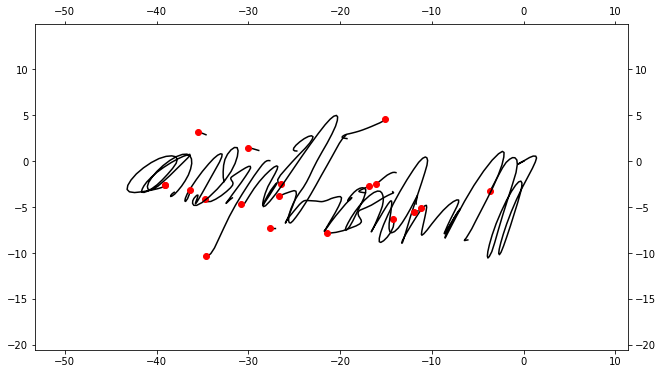

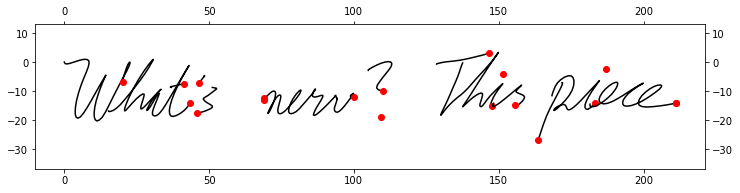

What 's new? This piece


In [8]:
draw(strokes[0])
res2 = destandarize(strokes, stroke_lengths, means, std) # for checking
draw(res2[0])
print(drawing.decode_ascii(strings[0]))

In [9]:
class HandwritingDataset(Dataset):
    def __init__(self, strokes, stroke_lengths):
        self.strokes = strokes
        self.stroke_lengths = stroke_lengths
        self.mask = self.getMask()
        
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx], self.stroke_lengths[idx], self.mask[idx]
    
    def getMask(self):
        mask = np.ones((self.strokes.shape[0], self.strokes.shape[1]-1))
        for i in range(self.strokes.shape[0]):
            # The mask needs to be 1 not till the last index or the index corresponding 
            # to the last character of stroke, but instead one before as the last char is 
            # always a special character (0, 0, 1) denoting the end of the stroke and 
            # we do not want to include loss computation on this as there is no point 
            # in teh stroke after this.
            mask[i][self.stroke_lengths[i]-1:] = 0
        return mask
    
train_dataset = HandwritingDataset(strokes[:10000], stroke_lengths[:10000])
test_dataset = HandwritingDataset(strokes[10000:], stroke_lengths[10000:])


In [10]:
dl = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=2,
    drop_last=True)

k = iter(dl)
for j in range(4):
    print("JJJJJJJJJJJJJJJJJ:", j)
    s, l, m = next(k)
    l0 = l[0]
    l1 = l[1]
    l
    s.shape
    m.shape

    print("Testing the 0th position of every stroke")
    s[:,0,:]

    print("testing the length location of stroke")
    s[0,l0-2:l0+2, :]
    s[1,l1-2:l1+2, :]

    print("testing the length location of mask")
    m[0,l0-2:l0+2]
    m[1,l1-2:l1+2]

JJJJJJJJJJJJJJJJJ: 0


tensor([709, 853], dtype=torch.int16)

torch.Size([2, 1200, 3])

torch.Size([2, 1199])

Testing the 0th position of every stroke


tensor([[0., 0., 0.],
        [0., 0., 0.]])

testing the length location of stroke


tensor([[-0.4368,  0.3418,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

tensor([[-0.5587, -0.3403,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

testing the length location of mask


tensor([1., 0., 0., 0.], dtype=torch.float64)

tensor([1., 0., 0., 0.], dtype=torch.float64)

JJJJJJJJJJJJJJJJJ: 1


tensor([ 610, 1004], dtype=torch.int16)

torch.Size([2, 1200, 3])

torch.Size([2, 1199])

Testing the 0th position of every stroke


tensor([[0., 0., 0.],
        [0., 0., 0.]])

testing the length location of stroke


tensor([[-0.1919,  0.1859,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

tensor([[-0.2703, -0.0022,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

testing the length location of mask


tensor([1., 0., 0., 0.], dtype=torch.float64)

tensor([1., 0., 0., 0.], dtype=torch.float64)

JJJJJJJJJJJJJJJJJ: 2


tensor([818, 493], dtype=torch.int16)

torch.Size([2, 1200, 3])

torch.Size([2, 1199])

Testing the 0th position of every stroke


tensor([[0., 0., 0.],
        [0., 0., 0.]])

testing the length location of stroke


tensor([[-0.2763,  0.0100,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

tensor([[-0.1544,  0.0017,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

testing the length location of mask


tensor([1., 0., 0., 0.], dtype=torch.float64)

tensor([1., 0., 0., 0.], dtype=torch.float64)

JJJJJJJJJJJJJJJJJ: 3


tensor([579, 832], dtype=torch.int16)

torch.Size([2, 1200, 3])

torch.Size([2, 1199])

Testing the 0th position of every stroke


tensor([[0., 0., 0.],
        [0., 0., 0.]])

testing the length location of stroke


tensor([[ 0.1801, -0.0142,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

tensor([[-0.4488, -0.1162,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

testing the length location of mask


tensor([1., 0., 0., 0.], dtype=torch.float64)

tensor([1., 0., 0., 0.], dtype=torch.float64)

In [11]:
from einops import rearrange 

class Prediction(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Prediction, self).__init__()
        self.input_size = input_size # 3
        self.hidden_size = hidden_size # 900
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(input_size+hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(input_size+hidden_size, hidden_size, batch_first=True)
        self.linearLayer = nn.Linear(3*hidden_size, output_size)
        
    def forward(self, x, prev_state):
        bs = x.shape[0]
        out_1, hid_1 = self.lstm1(x, prev_state[0])
        out_2, hid_2 = self.lstm2(torch.cat([x, out_1], dim=-1), prev_state[1])
        out_3, hid_3 = self.lstm3(torch.cat([x, out_2], dim=-1), prev_state[2])
        out_3 = rearrange(torch.cat([out_1, out_2, out_3], dim=-1), 'b l h -> (b l) h')
        out_4 = self.linearLayer(out_3)
        out_4 = rearrange(out_4, '(b l) o -> b l o', b = bs)
        return out_4, [hid_1, hid_2, hid_3]

In [12]:
inputs = torch.randn(2, 10, 3)
lengths = torch.tensor([5, 3])
inputs[0, 5:, :] = 0
inputs[1, 3:, :] = 0
inputs
lengths
p = Prediction(3, 4, 7)
h = torch.zeros(1, 2, 4)
prev_state = ((h, h), (h, h), (h, h))
p(inputs, prev_state)[0].shape

tensor([[[-0.8686,  0.3638, -0.0148],
         [-0.6403, -0.3424,  1.2554],
         [-1.0917, -1.4844,  0.2826],
         [-0.4669,  2.2181,  0.0858],
         [-0.5808, -0.6571,  0.5832],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[-0.7506, -0.4421, -2.1327],
         [ 1.5151,  0.6427, -0.1968],
         [ 0.1560,  0.7111, -0.0692],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]]])

tensor([5, 3])

torch.Size([2, 10, 7])

In [13]:
def get_mixture_params_from_output(outputs, bias=0):
    # outputs:  b, max_len-1, 6*n_mixtures+1
    pis = nn.Softmax(2)(outputs[:,:,:n_mixtures]*(1+bias))
    mus = rearrange(outputs[:,:,n_mixtures:3*n_mixtures], 'b l (n d) -> b l n d', d=2)
    
    sigmas = rearrange(torch.exp(outputs[:,:,3*n_mixtures:5*n_mixtures] - bias), 'b l (n d) -> b l n d', d=2) + eps
    phos = rearrange((1-eps)*torch.tanh(outputs[:,:,5*n_mixtures:6*n_mixtures]), 'b l (n d) -> b l n d', d=1)
    
    covs = torch.zeros(outputs.shape[0], outputs.shape[1], n_mixtures, 2, 2, device=device)
    covs[:,:,:,0,0] = sigmas[:,:,:,0]**2
    covs[:,:,:,1,1] = sigmas[:,:,:,1]**2
    covs[:,:,:,0,1] = phos[:,:,:,0] * sigmas[:,:,:,0] * sigmas[:,:,:,1]
    covs[:,:,:,1,0] = covs[:,:,:,0,1]
    
    return pis, mus, covs

def get_mixture_distributions_from_output(outputs):
    pis, mus, covs = get_mixture_params_from_output(outputs)
    
    distributions = torch.distributions.MultivariateNormal(mus, covs)
    return pis, distributions

def get_pen_lift_probs_from_output(outputs):
    return 1/(1 + torch.exp(outputs[:,:,-1]))

def nll(outputs, targets, mask_batch):
    # outputs:  b, max_len-1, 6*n_mixtures+1
    # targets: b, max_len-1, 3
    outputs = outputs.to(device)
    targets = targets.to(device)
    
    target_coords = targets[:,:,0:2].unsqueeze(2).repeat_interleave(
            torch.tensor([n_mixtures], device=device), dim=2)
    # target_coords: b, max_len-1, n_mixtures, 3
    stroke_lift = targets[:,:,-1] # b, max_len-1, 1
    
    pis, distributions = get_mixture_distributions_from_output(outputs)
    es = get_pen_lift_probs_from_output(outputs)

    probs = distributions.log_prob(target_coords) + eps
    loss1 = - torch.logsumexp(torch.log(pis) + probs, dim=2)
    loss2 = - torch.log(es)*stroke_lift
    loss3 = - torch.log(1 - es)*(1-stroke_lift)
    loss_per_point = loss1 + loss2 + loss3
    loss_per_point *= mask_batch
    
    return loss_per_point.sum()/outputs.shape[0]

In [14]:
def get_initial_prev_states(mode='train'):
    dim = batch_size if mode == 'train' else 1
    h01 = torch.zeros(1, dim, hidden_size, device=device)
    c01 = torch.zeros(1, dim, hidden_size, device=device)
    h02 = torch.zeros(1, dim, hidden_size, device=device)
    c02 = torch.zeros(1, dim, hidden_size, device=device)
    h03 = torch.zeros(1, dim, hidden_size, device=device)
    c03 = torch.zeros(1, dim, hidden_size, device=device)
    
    prev_states = [(h01, c01), (h02, c02), (h03, c03)]
    return prev_states

def get_next_point(model, point_prev, prev_states, bias=0):
    with torch.no_grad():
        outputs, prev_states = model(point_prev.unsqueeze(0).unsqueeze(0), prev_states)
        
        es = get_pen_lift_probs_from_output(outputs)
        pis, mus, covs = get_mixture_params_from_output(outputs, bias)
        
        sample_index = 0
        if n_mixtures > 1:
            sample_index = np.random.choice(
                range(n_mixtures),
                p = pis.squeeze().cpu().numpy())

        pen_off = torch.tensor(
            [np.random.binomial(1,es.item())],
            device=device)

        sample_point = torch.tensor(
            np.random.multivariate_normal(
                mus.squeeze(0).squeeze(0)[sample_index].cpu().numpy(),
                covs.squeeze(0).squeeze(0)[sample_index].cpu().numpy()),
            device=device)
        
        return torch.cat((sample_point, pen_off), dim=0), prev_states
        
def sample(model, bias=0):
    timestamps = seq_len
    sample_stroke = torch.zeros(timestamps, 3, device=device)
    prev_states = get_initial_prev_states("sample")
    stroke_end = False
    for i in range(timestamps-2):
        prev_point = sample_stroke[i]
        new_point, prev_states = get_next_point(model, prev_point, prev_states, bias)
        sample_stroke[i+1] = new_point
        if(new_point[0] == 0 and new_point[1] == 0 and new_point[2] == 1):
            print("Model decided to end the stroke")
            stroke_end = True
            break
    if (not stroke_end):
        sample_stroke[timestamps-1][2] = 1
    return sample_stroke

In [15]:
from einops import rearrange

def get_inputs_targets_from_batch(strokes_batch):
    inputs = strokes_batch[:, :-1, :]
    targets = strokes_batch[:, 1:, :]
    return inputs, targets

def train_batch(model, optimizer, strokes_batch, mask_batch, prev_states):
    optimizer.zero_grad()
    inputs, targets = get_inputs_targets_from_batch(strokes_batch)
    outputs, _ = model(inputs, prev_states)
    loss = nll(outputs, targets, mask_batch)
    loss.backward()
    #### Do Gradient clipping here if need be
    torch.nn.utils.clip_grad_value_(model.parameters(), 10)
    torch.nn.utils.clip_grad_value_(loss, 100)
    optimizer.step()
    return loss.item()

def save_model(model, model_name):
    base_dir = "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/"
    torch.save({
        'model_state_dict': model.state_dict(),
    }, base_dir + model_name)
    
def train(model, optimizer, train_dataloader, num_epochs):
    losses = []
    n_iter = 0
    total_loss = 0
    start = time.time()
    
    print_every = 50
    sample_every = print_every * 5
    
    prev_states = get_initial_prev_states("train")
    for epoch in range(num_epochs):
        
        for strokes_batch, lengths_batch, mask_batch in train_dataloader:
            max_len = lengths_batch.max()
            strokes_batch = strokes_batch.to(device)
            lengths_batch = lengths_batch.to(device)
            mask_batch = mask_batch.to(device)
            for idx in range(0, max_len-step_len, step_len):
                batch_loss = train_batch(
                    model,
                    optimizer,
                    strokes_batch[:, idx:idx+seq_len],
                    mask_batch[:, idx:idx+seq_len-1],
                    prev_states)
                prev_states = [(x[0].detach(), x[1].detach()) for x in prev_states]
                total_loss += batch_loss

                if n_iter % print_every == 0:
                    avg_loss = total_loss/print_every
                    losses.append(avg_loss)
                    print(f"iteration: {n_iter} "\
                          f"avg_loss: {avg_loss:.2f}, "\
                          f"timeSinceStart: {time.time() - start :.2f}, "\
                          f"Epoch: {epoch}")
                    total_loss = 0
                    save_model(model, model_name)

                if n_iter % sample_every == 0:
                    for bias in [0.1, 0.5, 5, 10]:
                        sample_stroke = sample(model, bias)
                        sample_stroke[1:, 0:2] *= torch.tensor(std, device=device)
                        sample_stroke[1:, 0:2] += torch.tensor(means, device=device)
                        draw(sample_stroke.cpu(), plot_end_points=False)
                
                n_iter += 1
    return losses

In [16]:

model = Prediction(input_size, hidden_size, 6*n_mixtures+1).to(device)
optim = torch.optim.Adam(model.parameters(), lr = lr)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
    drop_last=True)


/home/miniconda3/lib/python3.8/site-packages/torch/_tensor.py:992: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /opt/conda/conda-bld/pytorch_1627542741873/work/build/aten/src/ATen/core/TensorBody.h:802.)
  return self._grad


iteration: 0 avg_loss: 41.99, timeSinceStart: 1.08, Epoch: 0


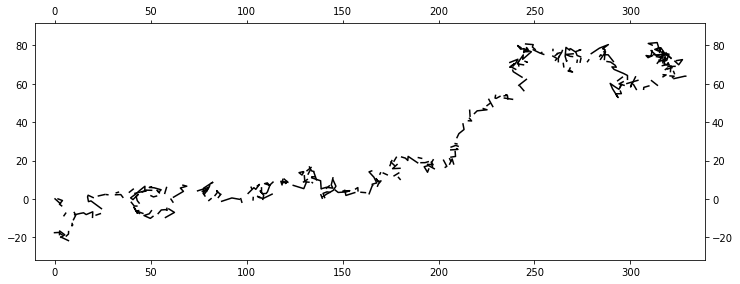

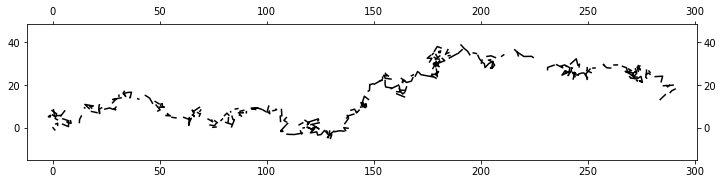

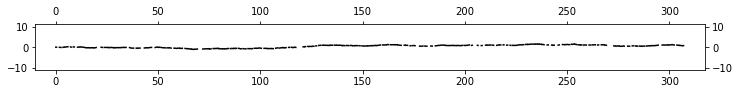

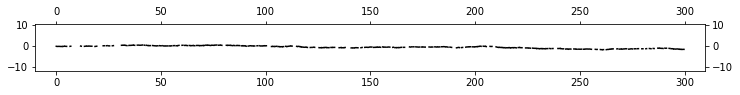

iteration: 50 avg_loss: 372.01, timeSinceStart: 42.84, Epoch: 0
iteration: 100 avg_loss: 56.57, timeSinceStart: 78.96, Epoch: 0
iteration: 150 avg_loss: -206.22, timeSinceStart: 114.74, Epoch: 0
iteration: 200 avg_loss: -422.44, timeSinceStart: 151.68, Epoch: 0
iteration: 250 avg_loss: -407.51, timeSinceStart: 186.81, Epoch: 0


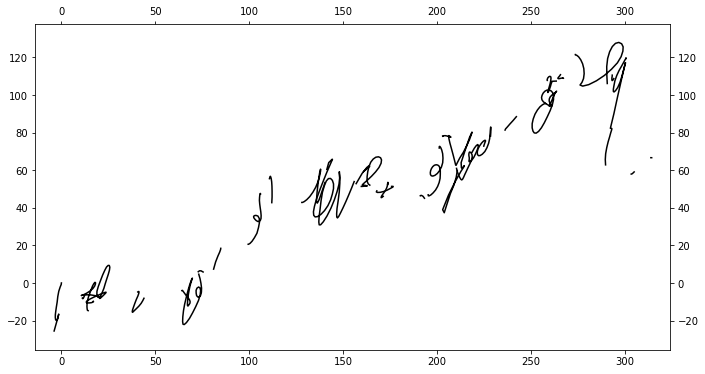

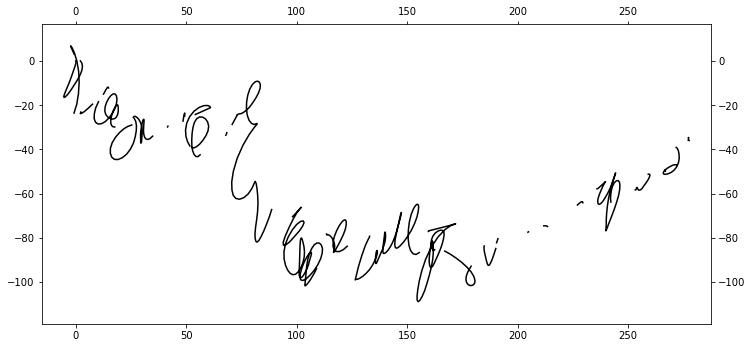

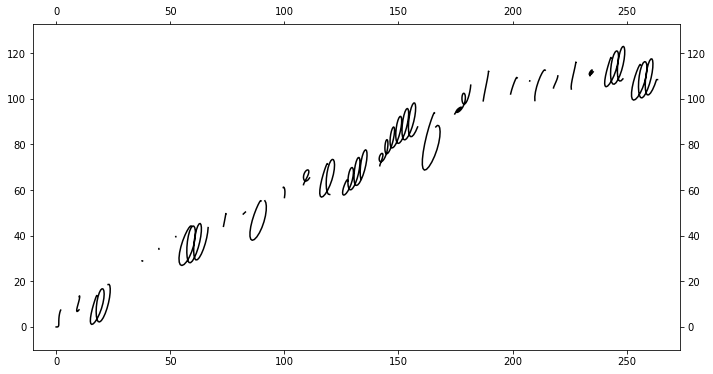

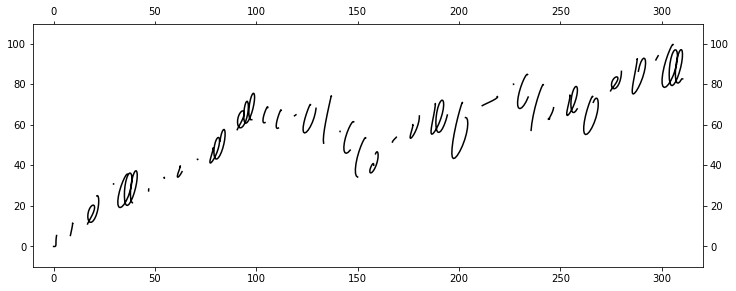

iteration: 300 avg_loss: -465.69, timeSinceStart: 227.89, Epoch: 0
iteration: 350 avg_loss: -457.98, timeSinceStart: 263.87, Epoch: 0
iteration: 400 avg_loss: -432.09, timeSinceStart: 300.01, Epoch: 0
iteration: 450 avg_loss: -499.77, timeSinceStart: 336.53, Epoch: 1
iteration: 500 avg_loss: -451.27, timeSinceStart: 371.67, Epoch: 1


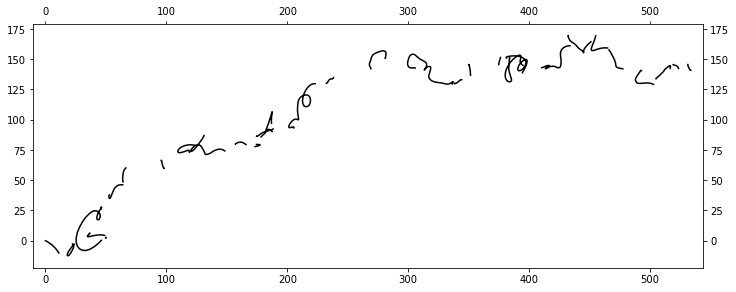

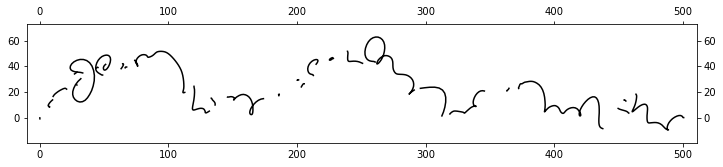

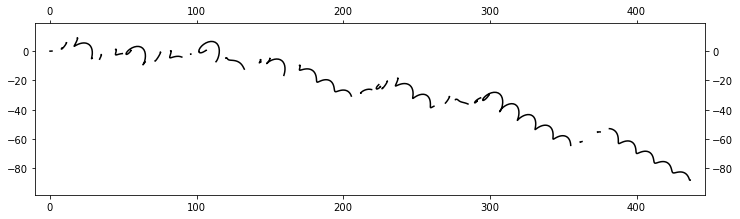

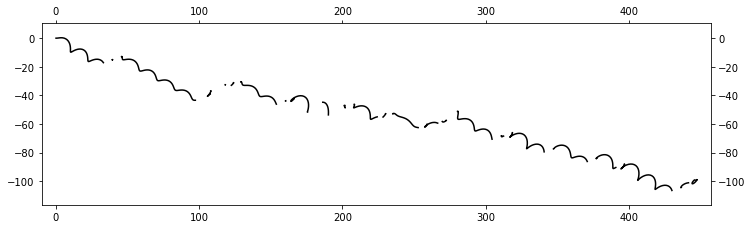

iteration: 550 avg_loss: -513.84, timeSinceStart: 413.34, Epoch: 1
iteration: 600 avg_loss: -480.03, timeSinceStart: 448.71, Epoch: 1
iteration: 650 avg_loss: -505.51, timeSinceStart: 485.85, Epoch: 1
iteration: 700 avg_loss: -554.00, timeSinceStart: 522.17, Epoch: 1
iteration: 750 avg_loss: -490.54, timeSinceStart: 558.09, Epoch: 1


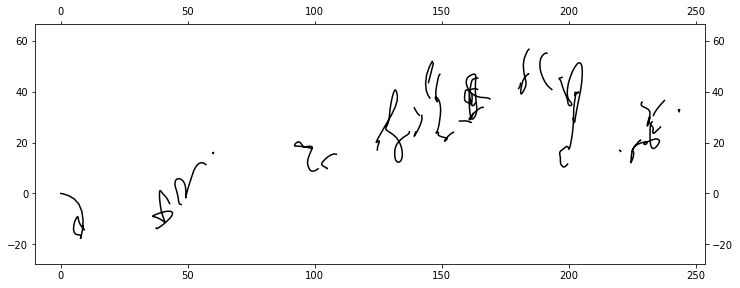

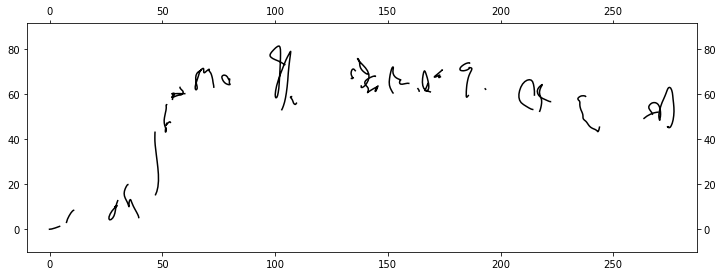

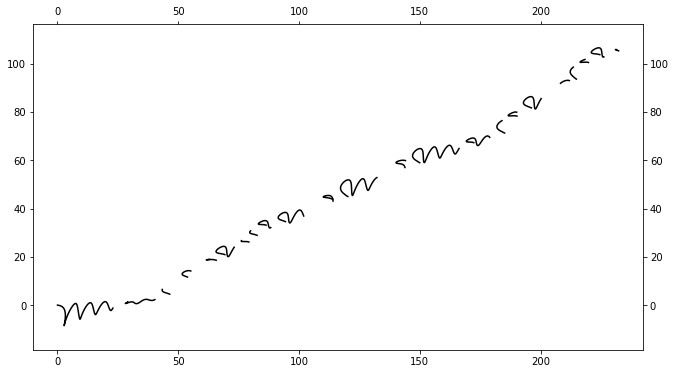

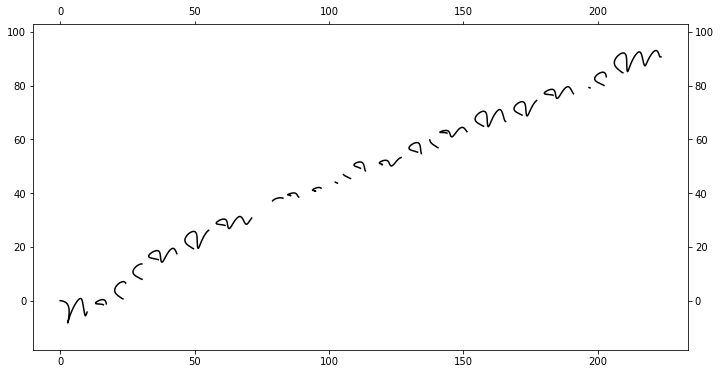

iteration: 800 avg_loss: -525.28, timeSinceStart: 599.62, Epoch: 1
iteration: 850 avg_loss: -552.75, timeSinceStart: 636.70, Epoch: 2
iteration: 900 avg_loss: -471.23, timeSinceStart: 671.83, Epoch: 2
iteration: 950 avg_loss: -553.44, timeSinceStart: 709.24, Epoch: 2
iteration: 1000 avg_loss: -569.35, timeSinceStart: 745.65, Epoch: 2


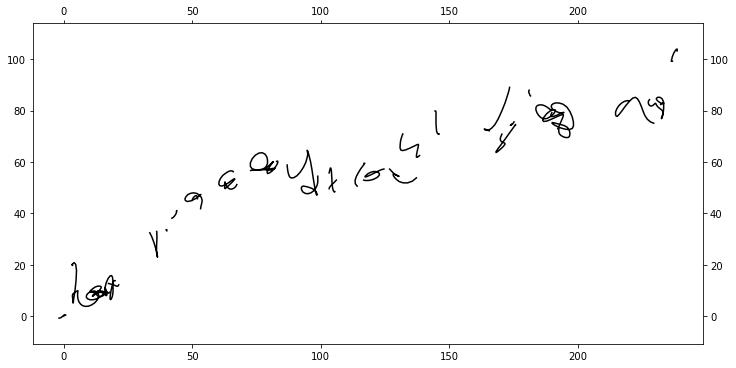

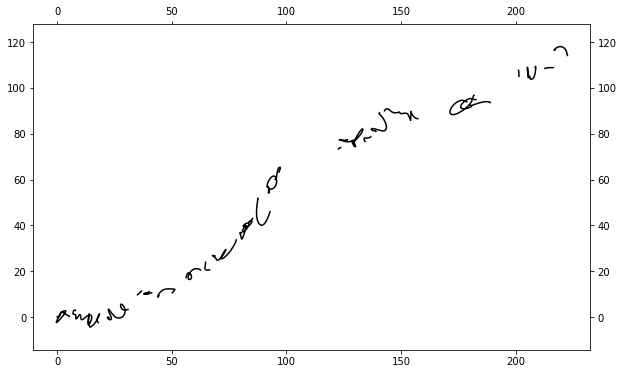

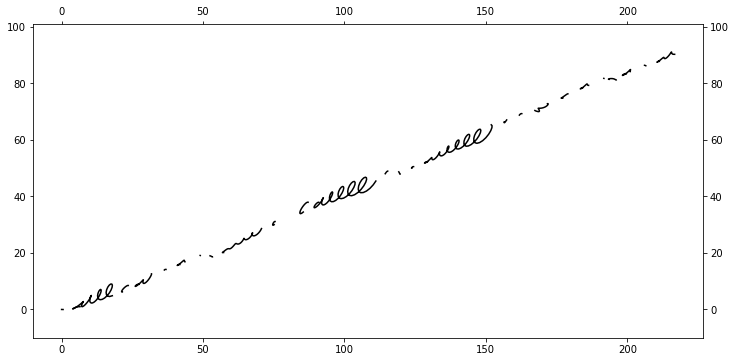

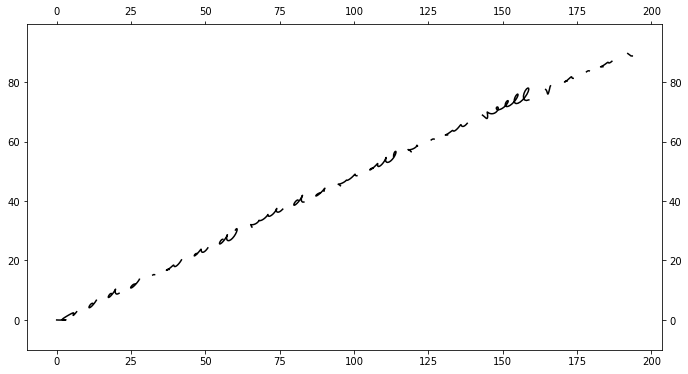

iteration: 1050 avg_loss: -531.04, timeSinceStart: 786.17, Epoch: 2
iteration: 1100 avg_loss: -537.61, timeSinceStart: 822.86, Epoch: 2
iteration: 1150 avg_loss: -546.47, timeSinceStart: 859.02, Epoch: 2
iteration: 1200 avg_loss: -494.84, timeSinceStart: 894.91, Epoch: 2
iteration: 1250 avg_loss: -585.56, timeSinceStart: 932.52, Epoch: 2


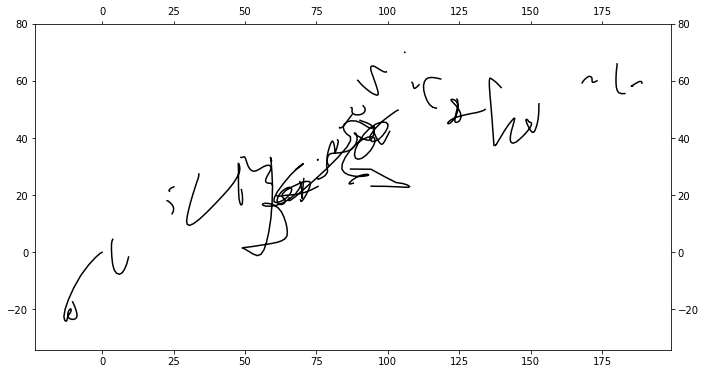

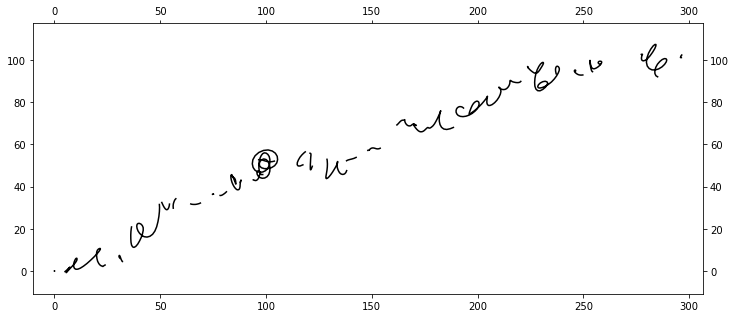

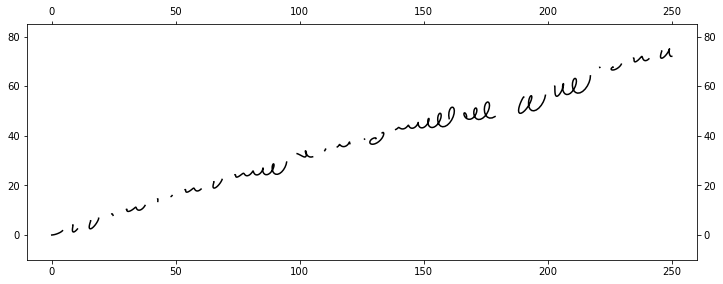

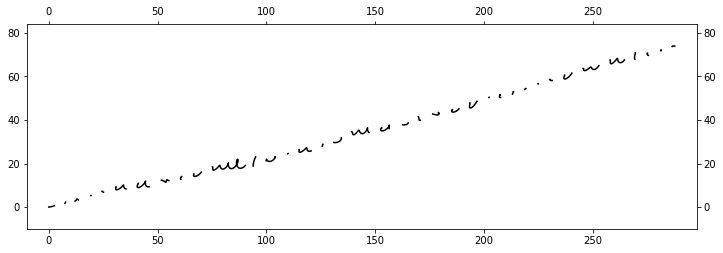

iteration: 1300 avg_loss: -557.44, timeSinceStart: 972.51, Epoch: 3
iteration: 1350 avg_loss: -498.90, timeSinceStart: 1008.59, Epoch: 3
iteration: 1400 avg_loss: -588.80, timeSinceStart: 1045.38, Epoch: 3
iteration: 1450 avg_loss: -507.97, timeSinceStart: 1080.37, Epoch: 3
iteration: 1500 avg_loss: -564.74, timeSinceStart: 1117.21, Epoch: 3


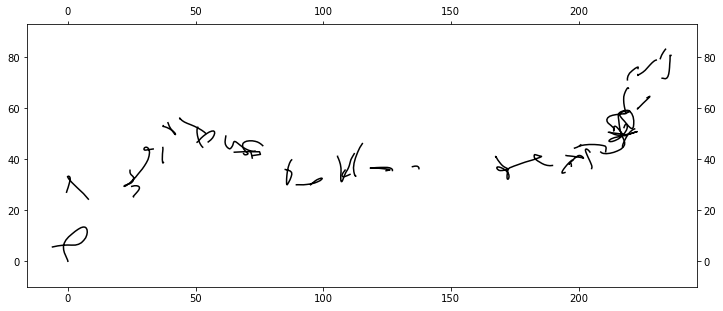

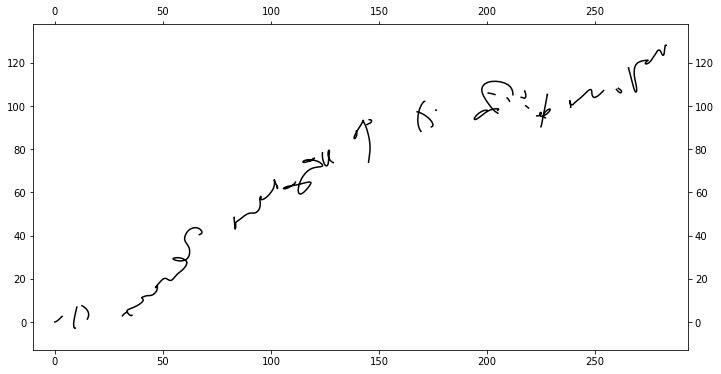

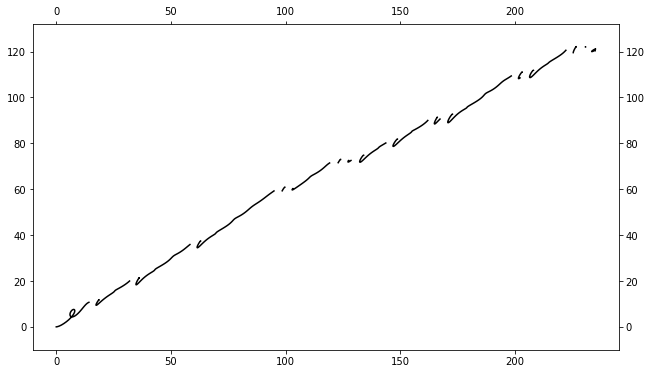

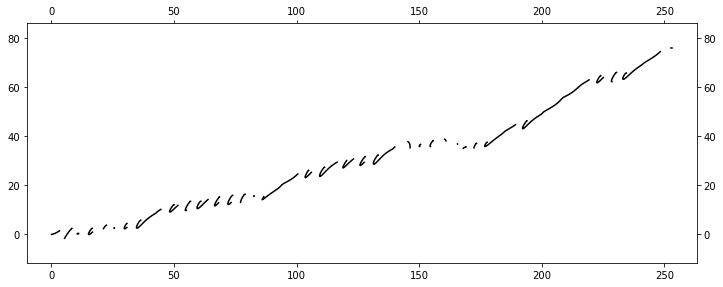

iteration: 1550 avg_loss: -564.65, timeSinceStart: 1157.86, Epoch: 3
iteration: 1600 avg_loss: -501.33, timeSinceStart: 1193.60, Epoch: 3
iteration: 1650 avg_loss: -591.60, timeSinceStart: 1231.53, Epoch: 3
iteration: 1700 avg_loss: -550.45, timeSinceStart: 1266.87, Epoch: 4
iteration: 1750 avg_loss: -536.34, timeSinceStart: 1303.30, Epoch: 4


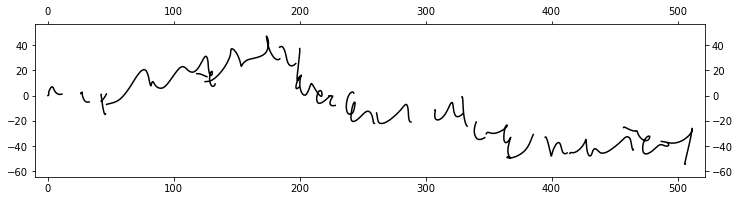

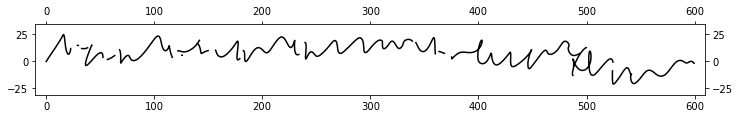

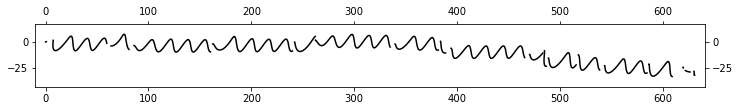

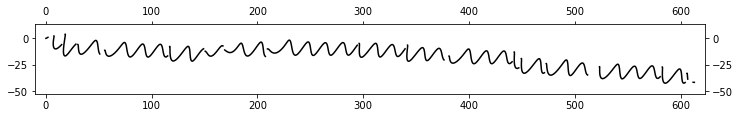

iteration: 1800 avg_loss: -606.85, timeSinceStart: 1344.39, Epoch: 4
iteration: 1850 avg_loss: -553.35, timeSinceStart: 1380.16, Epoch: 4
iteration: 1900 avg_loss: -545.24, timeSinceStart: 1417.17, Epoch: 4
iteration: 1950 avg_loss: -576.52, timeSinceStart: 1453.58, Epoch: 4
iteration: 2000 avg_loss: -594.87, timeSinceStart: 1489.91, Epoch: 4


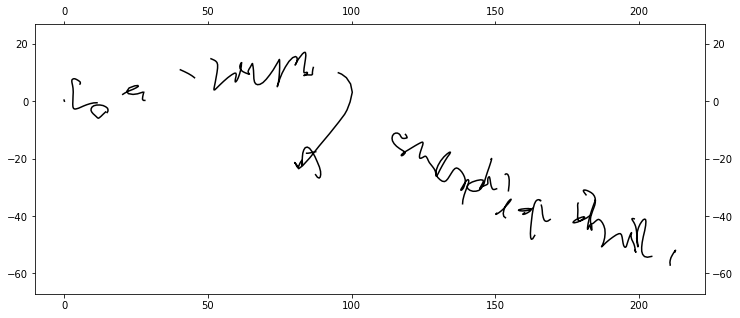

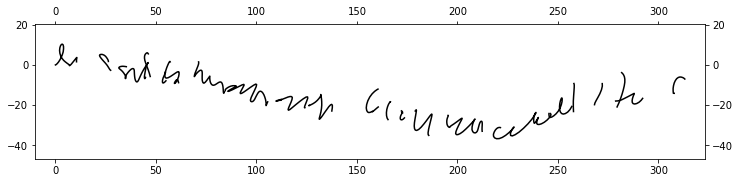

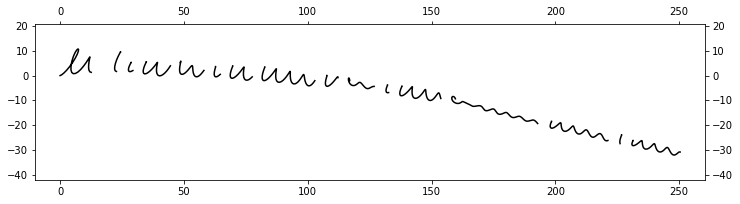

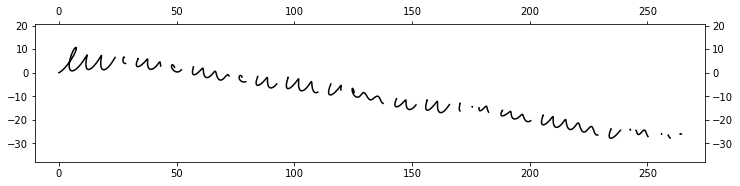

iteration: 2050 avg_loss: -575.25, timeSinceStart: 1530.68, Epoch: 4
iteration: 2100 avg_loss: -599.49, timeSinceStart: 1566.86, Epoch: 4
iteration: 2150 avg_loss: -531.39, timeSinceStart: 1602.68, Epoch: 5
iteration: 2200 avg_loss: -633.41, timeSinceStart: 1639.66, Epoch: 5
iteration: 2250 avg_loss: -540.32, timeSinceStart: 1674.74, Epoch: 5


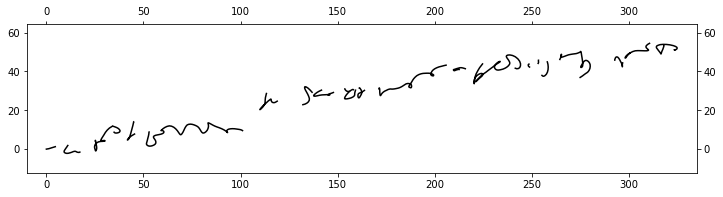

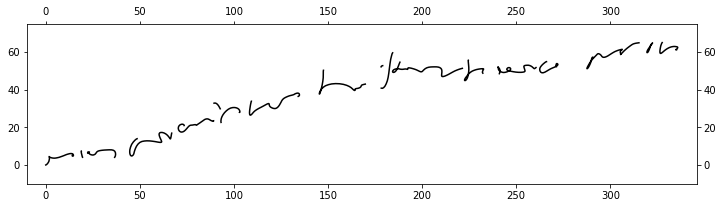

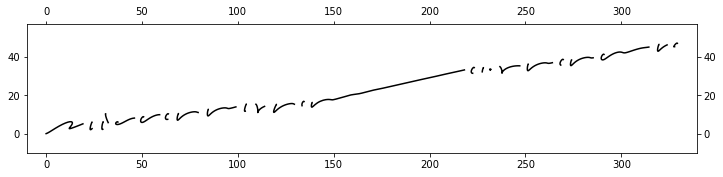

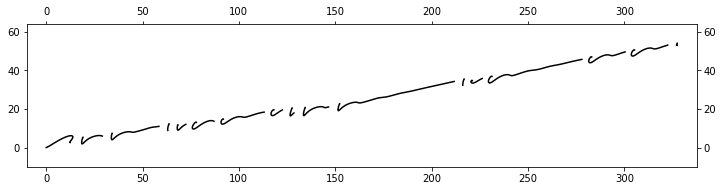

iteration: 2300 avg_loss: -586.29, timeSinceStart: 1716.11, Epoch: 5
iteration: 2350 avg_loss: -590.51, timeSinceStart: 1751.58, Epoch: 5
iteration: 2400 avg_loss: -547.87, timeSinceStart: 1787.96, Epoch: 5
iteration: 2450 avg_loss: -615.20, timeSinceStart: 1824.52, Epoch: 5
iteration: 2500 avg_loss: -544.04, timeSinceStart: 1860.50, Epoch: 5


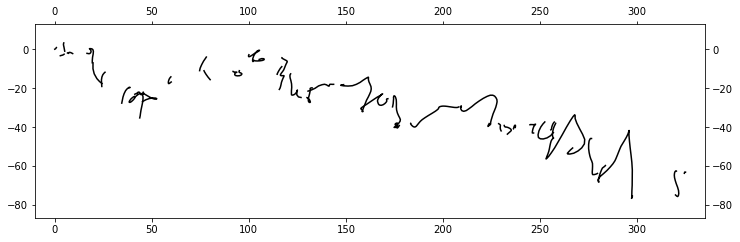

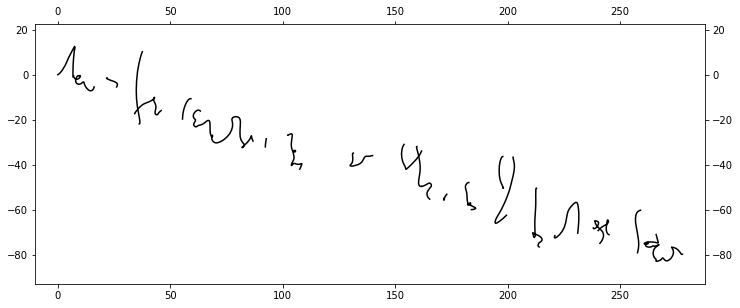

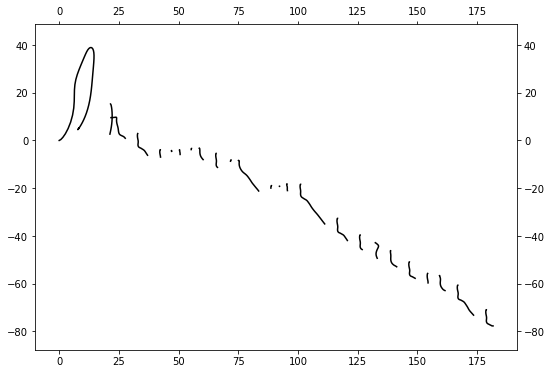

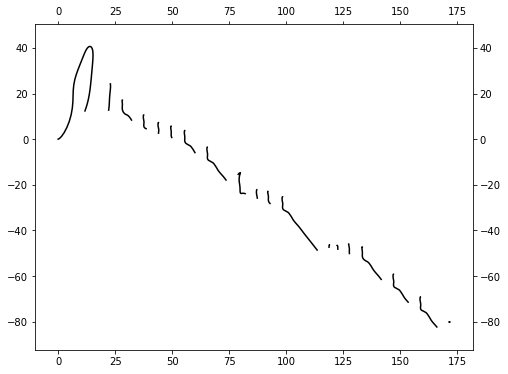

iteration: 2550 avg_loss: -592.10, timeSinceStart: 1901.63, Epoch: 6
iteration: 2600 avg_loss: -614.33, timeSinceStart: 1938.79, Epoch: 6
iteration: 2650 avg_loss: -527.23, timeSinceStart: 1973.66, Epoch: 6
iteration: 2700 avg_loss: -635.17, timeSinceStart: 2010.67, Epoch: 6
iteration: 2750 avg_loss: -613.84, timeSinceStart: 2047.23, Epoch: 6


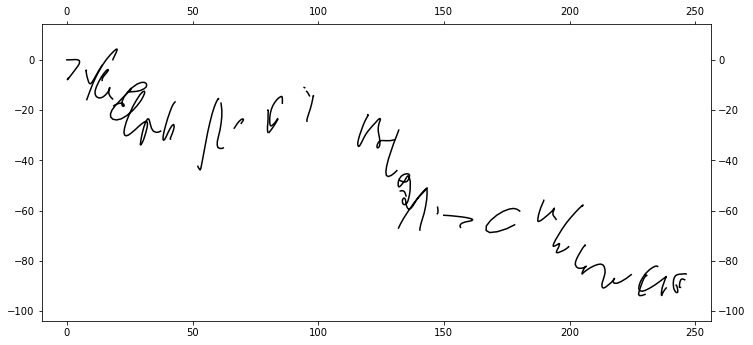

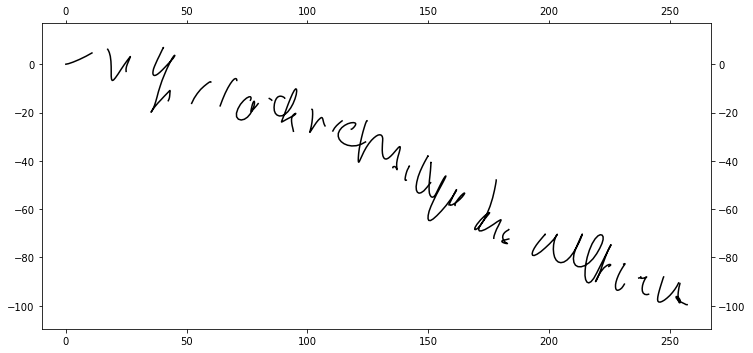

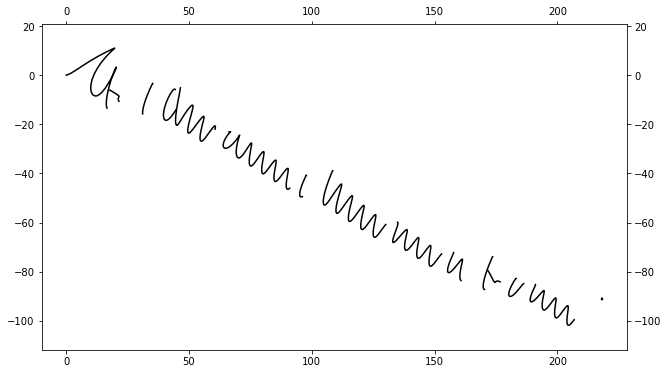

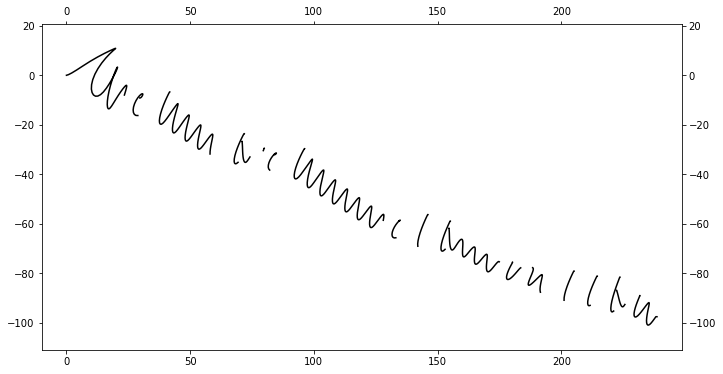

iteration: 2800 avg_loss: -582.91, timeSinceStart: 2087.71, Epoch: 6
iteration: 2850 avg_loss: -661.39, timeSinceStart: 2124.83, Epoch: 6
iteration: 2900 avg_loss: -570.00, timeSinceStart: 2160.06, Epoch: 6
iteration: 2950 avg_loss: -634.75, timeSinceStart: 2197.48, Epoch: 6
iteration: 3000 avg_loss: -640.20, timeSinceStart: 2233.62, Epoch: 7


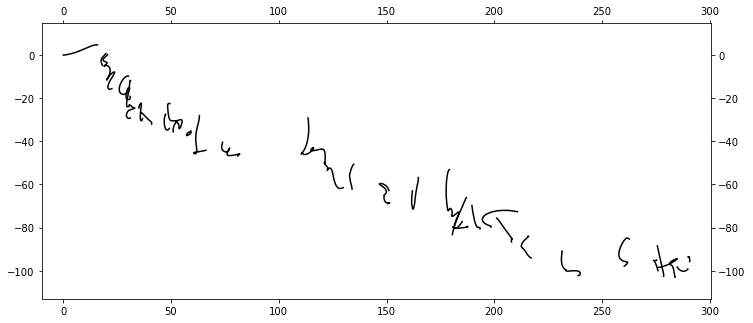

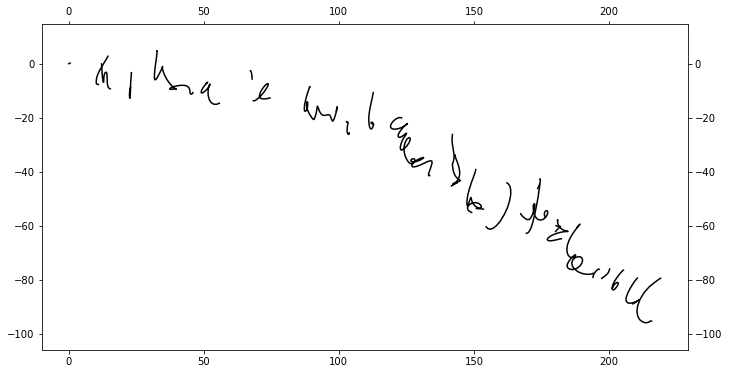

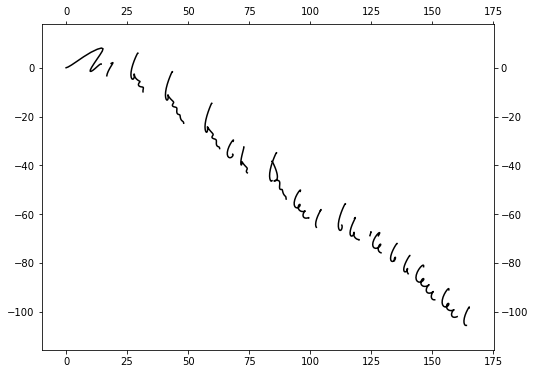

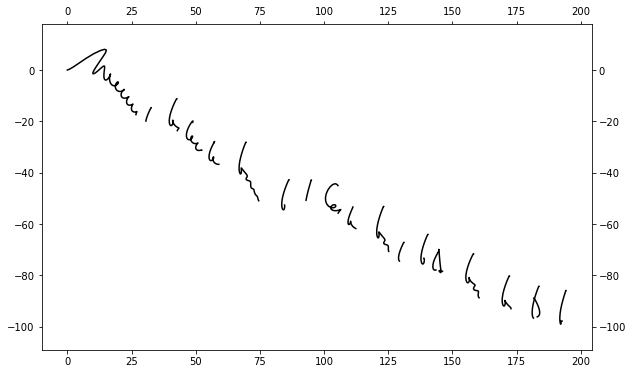

iteration: 3050 avg_loss: -597.28, timeSinceStart: 2274.01, Epoch: 7
iteration: 3100 avg_loss: -631.97, timeSinceStart: 2310.79, Epoch: 7
iteration: 3150 avg_loss: -577.57, timeSinceStart: 2345.99, Epoch: 7


ValueError: Expected parameter loc (Tensor of shape (256, 699, 20, 2)) of distribution MultivariateNormal(loc: torch.Size([256, 699, 20, 2]), covariance_matrix: torch.Size([256, 699, 20, 2, 2])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[[[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]]],


        ...,


        [[[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]]]], device='cuda:0', grad_fn=<ExpandBackward>)

In [17]:
train(model, optim, train_dataloader, n_epochs)

In [ ]:
prev_states

In [ ]:
m = Prediction(input_size, hidden_size, 6*n_mixtures+1).to(device)

inputs = torch.randn(batch_size, max_length, input_size, device=device)
inputs[:,0, 0:3] = 0
inputs[0,4, 0:2] = 0
inputs[0,1:5, 2] = 0
inputs[0,4, 2] = 1

inputs[1,3:, 0:3] = 0
inputs[1,2, 0:2] = 0
inputs[1,2, 2] = 1
inputs[1,1, 2] = 0
inputs

lengths = torch.tensor([5, 3])

packed_inp = pack_padded_sequence(
    inputs,
    lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
    batch_first=True)
targets = pack_padded_sequence(
    inputs[:,1:,:],
    lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
    batch_first=True)
packed_inp
targets
h = torch.zeros(1, 2, 4, device=device)
out, out1 = m(packed_inp, h, h)
print("out", out)
nll(out, targets.data)
print(out1)

In [ ]:
h0 = torch.zeros(1, batch_size, hidden_size, device=device)
c0 = torch.zeros(1, batch_size, hidden_size, device=device)
print(inputs.shape, lengths.shape, lengths)
train_batch(m, optim, inputs, lengths, h0, c0)
s = sample(m)
draw(s.cpu())

In [ ]:
start = torch.tensor([0, 0, 0])


In [ ]:
inputs = torch.randn(2, 5, 3)
inputs[:,0, 0:3] = 0
inputs[0,4, 0:2] = 0
inputs[0,1:5, 2] = 0
inputs[0,4, 2] = 1

inputs[1,3:, 0:3] = 0
inputs[1,2, 0:2] = 0
inputs[1,2, 2] = 1
inputs[1,1, 2] = 0
inputs
lengths = torch.tensor([5, 3])
lengths
ps = pack_padded_sequence(
            inputs,
            lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
            batch_first=True)
lstmLayer = nn.LSTM(3, 4, batch_first=True)
linLayer = nn.Linear(4, 7)


lstmout, _ = lstmLayer(ps)
lstmout
torch.cat((ps.data,lstmout.data), dim=-1)
linLayer(lstmLayer(ps)[0][0])
pad_packed_sequence(lstmLayer(ps)[0], batch_first=True)
